### This notebook shows examples of how to use the cyclops.query API on MIMIC-IV.

## Example 1. Get all patient encounters from 2015.

In [1]:
from sqlalchemy import select

from cyclops.query import mimic
from cyclops.query import utils as query_utils
from cyclops.query.interface import QueryInterface

patients = mimic.patients(years=[2015])
patients.run()
print(f"{len(patients.data)} rows extracted!")

2022-04-07 05:23:50,472 INFO cyclops.config  - Log file is /home/amritk/projects/cyclops/log.log
2022-04-07 05:23:50,806 INFO cyclops.query.utils - Log file is /home/amritk/projects/cyclops/log.log
2022-04-07 05:23:50,808 INFO cyclops.utils.profile - Log file is /home/amritk/projects/cyclops/log.log
2022-04-07 05:23:50,808 INFO cyclops.orm     - Log file is /home/amritk/projects/cyclops/log.log
2022-04-07 05:23:51,567 INFO cyclops.orm     - Database setup, ready to run queries!
2022-04-07 05:23:52,150 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:52,151 INFO cyclops.utils.profile - Finished executing function run_query in 0.573380 s


88488 rows extracted!


## Example 2. Get all patient encounters with diagnoses (`schizophrenia` in ICD long title), in the year 2015.

In [2]:
patients = mimic.patients(years=[2015])
patients_schizophrenia = mimic.diagnoses(substring="schizophrenia", patients=patients)
patients_schizophrenia.run()
print(f"{len(patients_schizophrenia.data)} rows extracted!")
patients_schizophrenia.data["icd_title"].value_counts()

2022-04-07 05:23:52,603 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:52,604 INFO cyclops.utils.profile - Finished executing function run_query in 0.440656 s


802 rows extracted!


Schizophrenia, unspecified                                                 380
Unspecified schizophrenia, unspecified                                     179
Paranoid schizophrenia                                                      77
Paranoid type schizophrenia, unspecified                                    51
Catatonic schizophrenia                                                     21
Unspecified schizophrenia, chronic                                          17
Paranoid type schizophrenia, chronic                                        12
Paranoid type schizophrenia, chronic with acute exacerbation                12
Other schizophrenia                                                         10
Other specified types of schizophrenia, unspecified                          8
Catatonic type schizophrenia, unspecified                                    7
Unspecified schizophrenia, chronic with acute exacerbation                   4
Catatonic type schizophrenia, chronic with acute exa

## Example 3. Advanced - uses regexp_match from sqlalchemy. Get all patient encounters with diagnoses (ICD long title contains `schizophrenia` and `chronic` ), in the year 2015.

In [3]:
patients = mimic.patients(years=[2015])
diagnoses = mimic.diagnoses(patients=patients)
subquery = (
    select(diagnoses.query)
    .where(diagnoses.query.c.icd_title.regexp_match("(?=.*schizophrenia)(?=.*chronic)"))
    .subquery()
)
patients_schizophrenia_chronic = diagnoses
patients_schizophrenia_chronic.query = subquery
patients_schizophrenia_chronic.run()
print(f"{len(patients_schizophrenia_chronic.data)} rows extracted!")

2022-04-07 05:23:53,666 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:53,668 INFO cyclops.utils.profile - Finished executing function run_query in 1.038439 s


57 rows extracted!


## Example 4. Advanced - uses cyclops.query.utils.starts_with helper function. Get all patient encounters with diagnoses (starts with `Paranoid` in ICD long title), in the year 2015.

In [4]:
patients = mimic.patients(years=[2015])
diagnoses = mimic.diagnoses(patients=patients)
subquery = (
    select(diagnoses.query)
    .where(query_utils.starts_with(diagnoses.query.c.icd_title, "Paranoid"))
    .subquery()
)
patients_schizophrenia = diagnoses
patients_schizophrenia.query = subquery
patients_schizophrenia.run()
print(f"{len(patients_schizophrenia.data)} rows extracted!")

2022-04-07 05:23:54,116 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:54,117 INFO cyclops.utils.profile - Finished executing function run_query in 0.425686 s


170 rows extracted!


## Example 5. Get all patient encounters with diagnoses (ICD code is F209).

In [5]:
patients = mimic.patients()
patients_f209 = mimic.diagnoses(diagnosis_codes=["F209"], patients=patients)
patients_f209.run()
print(f"{len(patients_f209.data)} rows extracted!")

2022-04-07 05:23:55,496 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:55,497 INFO cyclops.utils.profile - Finished executing function run_query in 1.359766 s


1442 rows extracted!


## Example 6. Get all patient encounters with diagnoses (`delirium` in ICD long title).

In [6]:
patients = mimic.patients()
patients_delirium = mimic.diagnoses(substring="delirium", patients=patients)
patients_delirium.run()
print(f"{len(patients_delirium.data)} rows extracted!")

2022-04-07 05:23:56,235 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:56,236 INFO cyclops.utils.profile - Finished executing function run_query in 0.723964 s


9087 rows extracted!


## Example 7. Get routine vital signs for patients from year 2015, limit to 100 rows.

In [7]:
patients = mimic.patients(years=[2015])
patients_vitals = mimic.events(category="Routine Vital Signs", patients=patients)
patients_vitals.run(limit=100)
print(f"{len(patients_vitals.data)} rows extracted!")

2022-04-07 05:23:56,351 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:23:56,352 INFO cyclops.utils.profile - Finished executing function run_query in 0.107474 s


100 rows extracted!


## Example 8. Get sodium lab tests for patients from year 2009, limit to 100 rows.

In [10]:
patients = mimic.patients(years=[2009])
patients_sodium_labs = mimic.events(substring="sodium", patients=patients)
patients_sodium_labs.run(limit=100)
print(f"{len(patients_sodium_labs.data)} rows extracted!")

2022-04-07 05:24:23,235 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:24:23,236 INFO cyclops.utils.profile - Finished executing function run_query in 0.156051 s


100 rows extracted!


## Example 9. Get respiratory events for patients from year 2009, limit to 100 rows.

In [15]:
patients = mimic.patients(years=[2009])
patients_respiratory = mimic.events(category="Respiratory")
patients_respiratory.run(limit=100)
print(f"{len(patients_respiratory.data)} rows extracted!")

2022-04-07 05:26:15,063 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:26:15,064 INFO cyclops.utils.profile - Finished executing function run_query in 0.017274 s


100 rows extracted!


## Example 10. Get heart rate of patients with delirium diagnoses, and plot some examples.

2022-04-07 05:31:37,373 INFO cyclops.orm     - Query returned successfully!
2022-04-07 05:31:37,374 INFO cyclops.utils.profile - Finished executing function run_query in 24.097248 s


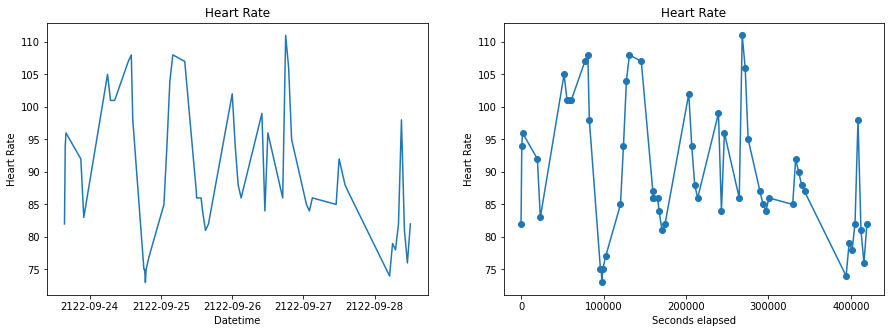

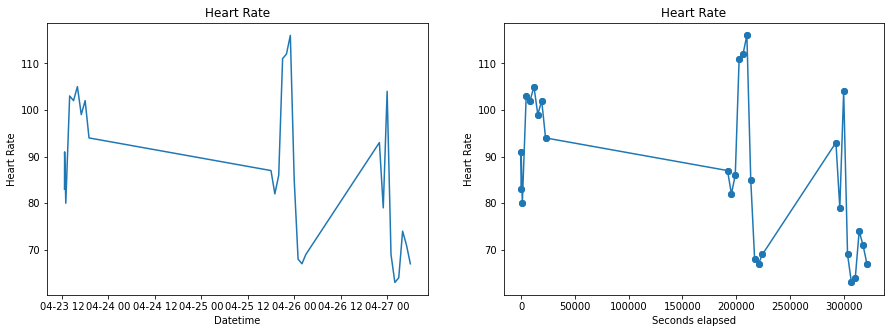

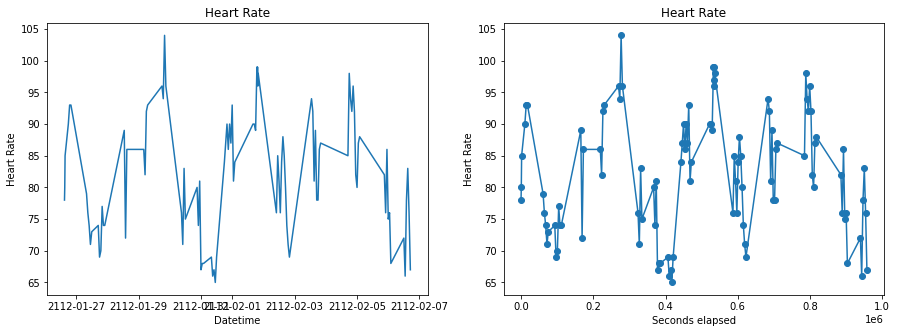

In [23]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

# Get heart rate
patients = mimic.patients()
patients_delirium = mimic.diagnoses(substring="delirium", patients=patients)
patients_delirium_heart_rate = mimic.events(
    labels="Heart Rate", patients=patients_delirium
)
patients_delirium_heart_rate.run(limit=1000)
df = patients_delirium_heart_rate.data

# Get only the labs with numeric value - This is just for now
# realistically we can find ways to utilize the other data!
df = df[df["valuenum"].notna()]

# Convert to datetime
df["charttime"] = pd.to_datetime(df["charttime"])

# Group by patient (subject_id), admission (hadm_id), ICU stay (stay_id), and event (itemid)
# NOTE: We may or may not want to group by hadm_id and/or stay_id
groupby = df.groupby(["subject_id", "hadm_id", "stay_id", "itemid"])

c = 0
for name, group in groupby:
    group.sort_values(by="charttime", inplace=True)

    label = group["label"].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(label)
    ax[0].plot(group["charttime"], group["valuenum"])
    ax[0].set_ylabel(label)
    ax[0].set_xlabel("Datetime")

    # Convert dates to seconds elapsed since first measurement
    group["charttime"] = (group["charttime"] - datetime.now()).dt.total_seconds()
    group["charttime"] -= group["charttime"].min()

    ax[1].set_title(label)
    ax[1].plot(group["charttime"], group["valuenum"])
    ax[1].scatter(group["charttime"], group["valuenum"])
    ax[1].set_ylabel(label)
    ax[1].set_xlabel("Seconds elapsed")
    c += 1
    if c > 2:
        break